In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
import lmfit
from pytz import timezone


{'name': 'propulsion',
 'ninputs': 2,
 'input_index': {'D': 0, 'Vi': 1},
 'noutputs': 2,
 'output_index': {'Ii': 0, 'Wm': 1},
 'nstates': 5,
 'state_index': {'propeller_x[0]': 0,
  'transmission_x[0]': 1,
  'motor_x[0]': 2,
  'esc_ctrl_x[0]': 3,
  'esc_power_x[0]': 4},
 'dt': 0,
 'params': {},
 'syslist': [<LinearIOSystem:propeller:['Wp']->['Tp']>,
  <LinearIOSystem:transmission:['Wm', 'Tp']->['Wp', 'Tm']>,
  <LinearIOSystem:motor:['Va', 'Tm']->['Wm', 'Ia']>,
  <LinearICSystem:esc:['D', 'Vi', 'Io']->['Vo', 'Ii']>],
 'syslist_index': {'propeller': 0, 'transmission': 1, 'motor': 2, 'esc': 3},
 'state_offset': [0, 1, 2, 3],
 'input_offset': [0, 1, 3, 5],
 'output_offset': [0, 1, 3, 5],
 'connect_map': array([[0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.

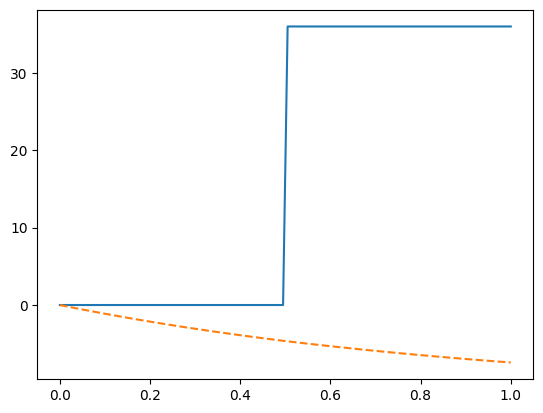

In [2]:
# Define the overall layout of the system

propulsion = ct.interconnect(
    [
        ct.rss(name="propeller", inputs=("Wp"), outputs=("Tp")),
        ct.rss(name="transmission", inputs=("Wm", "Tp"), outputs=("Wp", "Tm")),
        ct.rss(name="motor", inputs=("Va", "Tm"), outputs=("Wm", "Ia")),
        ct.interconnect(
            [
                ct.rss(name="ctrl", inputs=("Du"), outputs=("Dy")),
                ct.rss(name="power", inputs=("D", "Vi", "Io"), outputs=("Vo", "Ii")),
            ],
            name="esc",
            connections=[
                ["power.D", "ctrl.Dy"],
            ],
            inplist=["ctrl.Du", "power.Vi", "power.Io"],
            inputs=["D", "Vi", "Io"],
            outlist=["power.Vo", "power.Ii"],
            outputs=["Vo", "Ii"],
        ),
    ],
    name="propulsion",
    connections=[
        ["propeller.Wp", "transmission.Wp"],
        ["transmission.Tp", "propeller.Tp"],
        ["transmission.Wm", "motor.Wm"],
        ["motor.Tm", "transmission.Tm"],
        ["motor.Va", "esc.Vo"],
        ["esc.Io", "motor.Ia"],
    ],
    inplist=["esc.D", "esc.Vi"],
    inputs=["D", "Vi"],
    outlist=["esc.Ii", "motor.Wm"],
    outputs=["Ii", "Wm"],
)
display(propulsion.__dict__)

T = np.linspace(0, 1, 100)
D = np.array(
    [
        [0] * (len(T) // 2),
        [1] * (len(T) // 2),
    ]
).ravel()
Vi = np.ones_like(T) * 36
U = [D, Vi]

T, yout = ct.input_output_response(
    propulsion, T=T, U=U, solve_ivp_kwargs={"method": "Radau"}
)

plt.plot(T, U[0] * Vi)
plt.plot(T, yout[0], "--")
plt.show()


In [3]:
def add_noise(signal, target_snr_db=20):
    # Adding noise using target SNR. Ref: https://stackoverflow.com/a/53688043

    # Calculate signal power and convert to dB
    sig_avg_watts = np.mean(signal**2)
    sig_avg_db = 10 * np.log10(sig_avg_watts)

    # Calculate noise according to [2] then convert to watts
    noise_avg_db = sig_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)

    # Generate an sample of white noise
    mean_noise = 0
    noise = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(signal**2))

    # Noise up the original signal
    return signal + noise


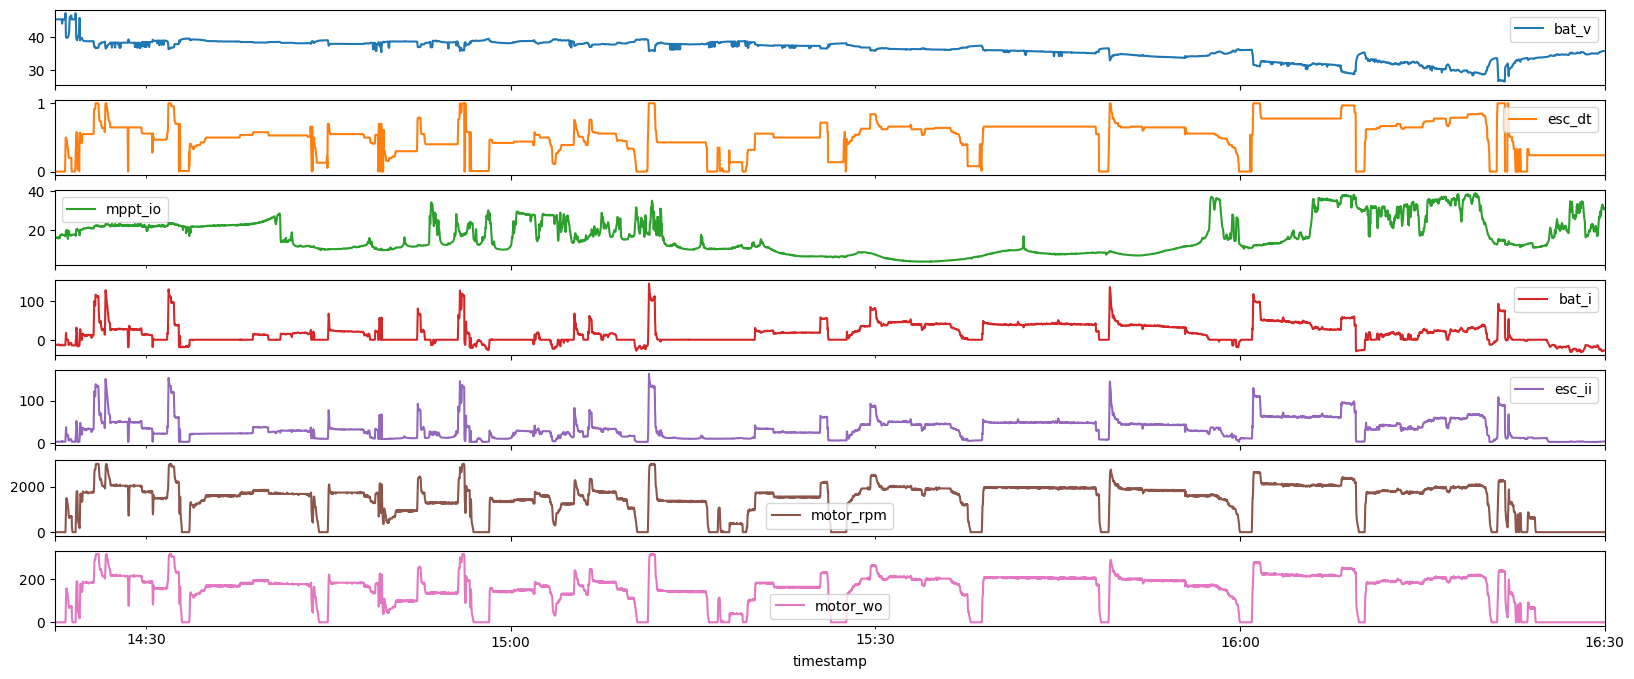

In [4]:
tzinfo = timezone("America/Sao_Paulo")
# start = pd.Timestamp(
#     year=2020, month=1, day=31, hour=12, minute=9, second=0, tzinfo=tzinfo
# ).tz_convert(None)
# end = pd.Timestamp(
#     year=2020, month=1, day=31, hour=12, minute=13, second=0, tzinfo=tzinfo
# ).tz_convert(None)

start = pd.Timestamp(
    year=2020, month=1, day=31, hour=11, minute=22, second=30, tzinfo=tzinfo
).tz_convert(None)
end = pd.Timestamp(
    year=2020, month=1, day=31, hour=13, minute=30, second=0, tzinfo=tzinfo
).tz_convert(None)

df = pd.read_csv("../../../models/2020/boat_data_1s.csv")
# df = pd.read_csv("../../../models/2020/boat_data_100ms.csv")
df["timestamp"] = pd.DatetimeIndex(df["timestamp"]).tz_convert(None)
df = df.set_index("timestamp")

df = df.loc[
    (df.index >= start) & (df.index <= end),
    ["bat_v", "esc_dt", "mppt_io", "bat_i", "esc_ii", "motor_rpm"],
]
df = df.interpolate(method="time")
assert df is not None

rpm_to_radps = (2 * np.pi) / 60
df["motor_wo"] = df["motor_rpm"] * rpm_to_radps

df.plot(subplots=True, figsize=(20, 8))
plt.show()


<NonlinearIOSystem>: propeller
Inputs (1): ['Wp']
Outputs (1): ['Tp']
States (0): []

Update: None
Output: <bound method Propeller._outputs of <class '__main__.Propeller'>>


,Wp,Tp
time,,
3.599,300.0,8.654851


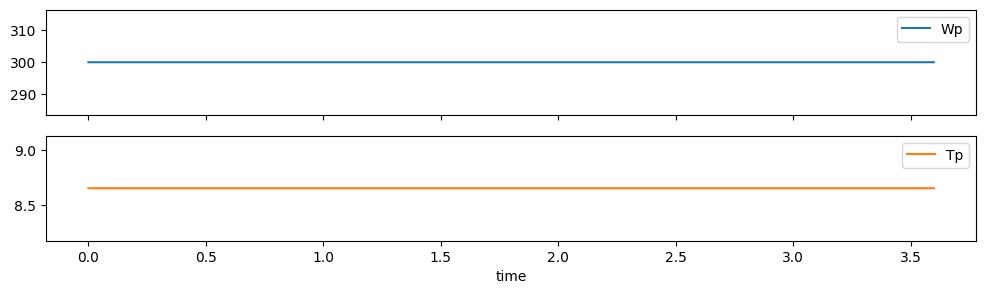

In [16]:
class Propeller:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Get the parameter values
        Kp = params["Kp"]
        D = params["D"]
        rho = params["rho"]

        # Get the inputs
        Wm = u

        # Returns the Torque required by the Propeller
        return D**5 * rho * Kp * Wm**2

    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name="propeller",
            states=None,
            inputs="Wp",
            outputs="Tp",
            params=params,
        )


propeller = Propeller.build({"Kp": 2e-4, "D": 8.5 * 0.0254, "rho": 1025})
print(propeller)


T = np.arange(0, 3600) / 1000
Wm = np.ones_like(T) * 300

res = ct.input_output_response(
    propeller, T=T, U=Wm, solve_ivp_kwargs={"method": "Radau"}
)
res.output_labels = propeller.output_labels
res.input_labels = propeller.input_labels
res.state_labels = propeller.state_labels
outputs = res.to_pandas().set_index("time")
display(outputs.tail(1))
outputs.plot(subplots=True, figsize=(12, 3))
plt.show()


In [6]:
class Transmission:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Get the parameter values
        eff = params["trans_eff"]
        Kr = params["Kr"]  # gear ratio as `output speed / input speed`

        # Get the inputs
        Wm, Tp = u

        #
        Wp = Wm * Kr
        Tm = Tp * Kr / eff

        return (Wp, Tm)

    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name="transmission",
            states=None,
            inputs=("Wm", "Tp"),
            outputs=("Wp", "Tm"),
            params=params,
        )


transmission = Transmission.build({"trans_eff": 1.0, "Kr": 13 / 22})
display(transmission.__dict__)


{'name': 'transmission',
 'ninputs': 2,
 'input_index': {'Wm': 0, 'Tp': 1},
 'noutputs': 2,
 'output_index': {'Wp': 0, 'Tm': 1},
 'nstates': 0,
 'state_index': {},
 'dt': 0,
 'params': {'trans_eff': 1.0, 'Kr': 0.5909090909090909},
 'updfcn': None,
 'outfcn': <bound method Transmission._outputs of <class '__main__.Transmission'>>,
 '_current_params': {'trans_eff': 1.0, 'Kr': 0.5909090909090909}}

{'name': 'motor',
 'ninputs': 2,
 'input_index': {'Va': 0, 'Tm': 1},
 'noutputs': 2,
 'output_index': {'Ia': 0, 'Wm': 1},
 'nstates': 2,
 'state_index': {'Ia': 0, 'Wm': 1},
 'dt': 0,
 'params': {},
 'A': array([[-3.08282600e+02, -1.61903297e+03],
        [ 9.49797468e-02, -8.55218299e-04]]),
 'B': array([[ 1.56250000e+04,  0.00000000e+00],
        [ 0.00000000e+00, -9.16632689e-01]]),
 'C': array([[1., 0.],
        [0., 1.]]),
 'D': array([[0., 0.],
        [0., 0.]])}

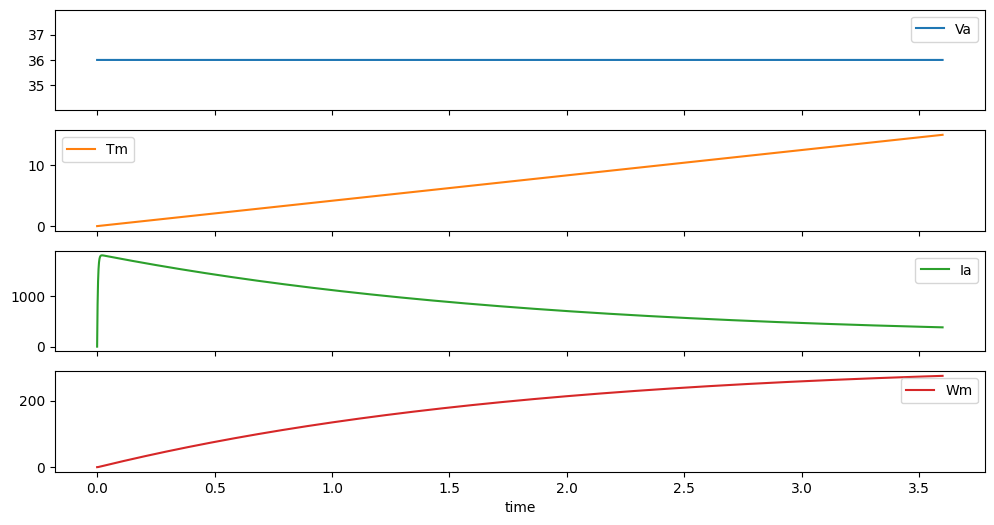

In [7]:
class Motor:
    @classmethod
    def build(cls, params: dict):
        Kv = params["Kv"]
        Ra = params["Ra"]
        La = params["La"]
        Jm = params["Jm"]
        Bm = params["Bm"]

        # State Transition matrix, shape 'n,n' -> '2x2'
        A = np.array(
            [
                [-Ra / La, -Kv / La],
                [+Kv / Jm, -Bm / Jm],
            ],
            dtype=np.float64,
        )

        # Input matrix, shape 'n,m' -> '2x2'
        B = np.array(
            [
                [+1 / La, 0],
                [0, -1 / Jm],
            ],
            dtype=np.float64,
        )

        # Output matrix, shape 'p,n' -> '3x2'
        C = np.array(
            [
                [1, 0],
                [0, 1],
                # [0, 0],
                # [Kv, 0],
            ],
            dtype=np.float64,
        )

        # Remaining matrix, shape 'p,m' -> '3x2'
        D = np.array(
            [
                [0, 0],
                [0, 0],
                # [1, 0],
                # [0, 0],
            ],
            dtype=np.float64,
        )

        return ct.ss(
            A,
            B,
            C,
            D,
            name="motor",
            states=("Ia", "Wm"),
            inputs=("Va", "Tm"),
            outputs=("Ia", "Wm"),  # , "Va", "Tm"),
        )


def motor_eff(v_a, i_a, params: dict):
    Ra = params["Ra"]
    Bm = params["Bm"]
    Kv = params["Kv"]

    # Prevent division by zero
    i_a = np.clip(i_a, a_min=0.01, a_max=None)

    eta_p1 = -(Bm * Ra**2 * i_a) / (Kv**2 * v_a)
    eta_p2 = 2 * Bm * Ra / Kv**2
    eta_p3 = -(Bm * v_a) / (Kv**2 * i_a)
    eta_p4 = -(Ra * i_a) / v_a
    eta = 1 + eta_p1 + eta_p2 + eta_p3 + eta_p4

    return np.clip(eta, a_min=0, a_max=1)


motor = Motor.build(
    {
        "Ra": 0.019730086429421013,
        "La": 64e-06,
        "Bm": 0.000933,
        "Jm": 1.0909495280781845,
        "Kv": 0.10361811,
    }
)
display(motor.__dict__)

T = np.arange(0, 3600) / 1000
Va = np.ones_like(T) * 36
Tm = np.linspace(0, 15, len(T))

res = ct.forced_response(motor, T, U=[Va, Tm], X0=[0, 0])
res.output_labels = motor.output_labels
res.input_labels = motor.input_labels
res.state_labels = motor.state_labels
outputs = res.to_pandas().set_index("time")
outputs.plot(subplots=True, figsize=(12, 6))
plt.show()


In [8]:
motor = Motor.build(
    {
        "Ra": 0.019730086429421013,
        "La": 28e-06,
        "Bm": 0.002,
        "Jm": 1.0909495280781845,
        "Kv": 0.10390329,
    }
)

T = np.linspace(0, 100, 100)
Va = np.ones_like(T) * 36
Tm = np.zeros_like(T)

res = ct.forced_response(motor, T, U=[Va, Tm], X0=[0, 0])
res.output_labels = motor.output_labels
res.input_labels = motor.input_labels
res.state_labels = motor.state_labels
outputs = res.to_pandas().set_index("time")
# outputs.plot(subplots=True, figsize=(12, 6))
# plt.show()
outputs.tail(1)


,Va,Tm,Ia,Wm
time,,,,
100.0,36.0,0.0,6.644915,345.21424


{'name': 'esc_power',
 'ninputs': 3,
 'input_index': {'D': 0, 'Vi': 1, 'Io': 2},
 'noutputs': 2,
 'output_index': {'Vo': 0, 'Ii': 1},
 'nstates': 0,
 'state_index': {},
 'dt': 0,
 'params': {},
 'updfcn': None,
 'outfcn': <bound method ESC_power._outputs of <class '__main__.ESC_power'>>,
 '_current_params': {}}

{'display_format': 'poly',
 'name': 'esc_ctrl',
 'ninputs': 1,
 'input_index': {'Du': 0},
 'noutputs': 1,
 'output_index': {'Dy': 0},
 'nstates': None,
 'state_index': {},
 'dt': 0,
 'num': [[array([-1.,  1.])]],
 'den': [[array([1., 1.])]]}

{'syslist': [<LinearIOSystem:esc_ctrl:['Du']->['Dy']>,
  <NonlinearIOSystem:esc_power:['D', 'Vi', 'Io']->['Vo', 'Ii']>],
 'syslist_index': {'esc_ctrl': 0, 'esc_power': 1},
 'state_offset': [0, 1],
 'input_offset': [0, 1],
 'output_offset': [0, 1],
 'name': 'esc',
 'ninputs': 3,
 'input_index': {'D': 0, 'Vi': 1, 'Io': 2},
 'noutputs': 2,
 'output_index': {'Vo': 0, 'Ii': 1},
 'nstates': 1,
 'state_index': {'esc_ctrl_x[0]': 0},
 'dt': 0,
 'params': {'ctrl_delay_s': 2.0},
 'connect_map': array([[0., 0., 0.],
        [1., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'input_map': array([[1., 0., 0.],
        [0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 'output_map': array([[0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])}

{'syslist': [<LinearIOSystem:esc_ctrl:['Du']->['Dy']>,
  <NonlinearIOSystem:esc_power:['D', 'Vi', 'Io']->['Vo', 'Ii']>],
 'syslist_index': {'esc_ctrl': 0, 'esc_power': 1},
 'state_offset': [0, 1],
 'input_offset': [0, 1],
 'output_offset': [0, 1],
 'name': 'esc',
 'ninputs': 3,
 'input_index': {'D': 0, 'Vi': 1, 'Io': 2},
 'noutputs': 2,
 'output_index': {'Vo': 0, 'Ii': 1},
 'nstates': 1,
 'state_index': {'esc_ctrl_x[0]': 0},
 'dt': 0,
 'params': {'ctrl_delay_s': 2.0},
 'connect_map': array([[0., 0., 0.],
        [1., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'input_map': array([[1., 0., 0.],
        [0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 'output_map': array([[0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])}

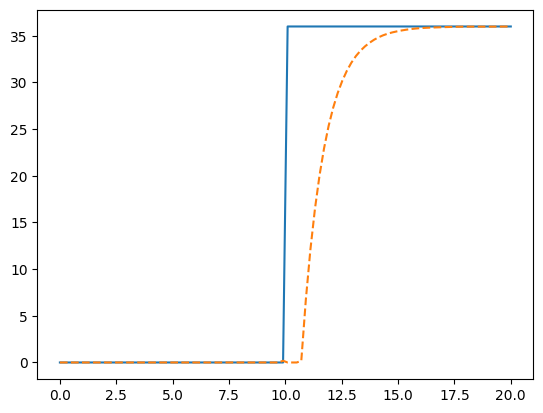

In [9]:
import bisect


class ESC_power:
    @classmethod
    def _eff(cls, Po):
        def interpolate_lut(lookup_table: dict, value: np.float64):
            sorted_keys = sorted(lookup_table.keys())

            # Check if value is below the lowest key
            if value < sorted_keys[0]:
                return lookup_table[sorted_keys[0]]

            # Check if value is above the highest key
            if value > sorted_keys[-1]:
                return lookup_table[sorted_keys[-1]]

            # Find the nearest lower and higher keys using bisect_left
            index = bisect.bisect_left(sorted_keys, value)  # type: ignore
            if sorted_keys[index] == value:
                return lookup_table[value]

            low = sorted_keys[index - 1]
            high = sorted_keys[index]
            low_value = lookup_table[low]
            high_value = lookup_table[high]
            interpolation_ratio = (value - low) / (high - low)
            interpolated_value = (
                low_value + (high_value - low_value) * interpolation_ratio
            )

            return interpolated_value

        eff_lut = {
            101.01010101010101: 0.9008659875674055,
            202.02020202020202: 0.8965339550850506,
            303.030303030303: 0.8917916889224153,
            404.04040404040404: 0.8867616989781612,
            505.0505050505051: 0.8815063237069551,
            606.060606060606: 0.8760640640983648,
            707.070707070707: 0.8704613108462592,
            808.0808080808081: 0.8647173928470953,
            909.0909090909091: 0.8588471353429659,
            1010.1010101010102: 0.8528623034471401,
            1111.111111111111: 0.8467724820313317,
            1212.121212121212: 0.8405856442518611,
            1313.1313131313132: 0.8343085360886341,
            1414.141414141414: 0.8279469462192784,
            1515.1515151515152: 0.8215059012756635,
            1616.1616161616162: 0.8149898107718802,
            1717.171717171717: 0.8084025770447947,
            1818.1818181818182: 0.801747680235099,
            1919.1919191919192: 0.795028245059753,
            2020.2020202020203: 0.7882470940383721,
            2121.212121212121: 0.7814067904668033,
            2222.222222222222: 0.7745096735105957,
            2323.2323232323233: 0.7675578871582908,
            2424.242424242424: 0.7605534043308197,
            2525.252525252525: 0.7534980471266763,
            2626.2626262626263: 0.7463935039528915,
            2727.2727272727275: 0.7392413441228506,
            2828.282828282828: 0.7320430303759573,
            2929.2929292929293: 0.7247999296790111,
            3030.3030303030305: 0.7175133225965188,
            3131.313131313131: 0.7101844114611389,
            3232.3232323232323: 0.7028143275318144,
            3333.3333333333335: 0.6954041372928614,
            3434.343434343434: 0.6879548480201204,
            3535.3535353535353: 0.6804674127185764,
            3636.3636363636365: 0.672942734518424,
            3737.373737373737: 0.6653816706024132,
            3838.3838383838383: 0.6577850357258191,
            3939.3939393939395: 0.6501536053809298,
            4040.4040404040406: 0.6424881186501781,
            4141.414141414141: 0.6347892807855944,
            4242.424242424242: 0.6270577655468845,
            4343.434343434344: 0.6192942173259471,
            4444.444444444444: 0.6114992530818636,
            4545.454545454545: 0.6036734641072012,
            4646.464646464647: 0.5958174176437707,
            4747.474747474747: 0.5879316583636692,
            4848.484848484848: 0.5800167097294712,
            4949.49494949495: 0.5720730752457568,
            5050.50505050505: 0.5641012396126931,
            5151.515151515152: 0.5561016697911536,
            5252.525252525253: 0.5480748159877579,
            5353.535353535353: 0.5400211125672819,
            5454.545454545455: 0.5319409788990701,
            5555.555555555556: 0.5238348201433536,
            5656.565656565656: 0.5157030279827612,
            5757.575757575758: 0.507545981303758,
            5858.585858585859: 0.49936404683225344,
            5959.595959595959: 0.4911575797272059,
            6060.606060606061: 0.48292692413566196,
            6161.616161616162: 0.4746724137123382,
            6262.626262626262: 0.46639437210655776,
            6363.636363636364: 0.45809311341908643,
            6464.646464646465: 0.44976894263117606,
            6565.656565656565: 0.4414221560079176,
            6666.666666666667: 0.4330530414778128,
            6767.676767676768: 0.42466187899030655,
            6868.686868686868: 0.4162489408528697,
            6969.69696969697: 0.4078144920490856,
            7070.707070707071: 0.39935879053907475,
            7171.717171717171: 0.3908820875434692,
            7272.727272727273: 0.3823846278120663,
            7373.737373737374: 0.3738666498781815,
            7474.747474747474: 0.3653283862996537,
            7575.757575757576: 0.35677006388737065,
            7676.767676767677: 0.3481919039221196,
            7777.777777777777: 0.3395941223605077,
            7878.787878787879: 0.33097693003063533,
            7979.79797979798: 0.32234053281815744,
            8080.808080808081: 0.3136851318433247,
            8181.818181818182: 0.3050109236295425,
            8282.828282828283: 0.296318100263962,
            8383.838383838383: 0.28760684955056515,
            8484.848484848484: 0.27887735515618506,
            8585.858585858587: 0.27012979674986903,
            8686.868686868687: 0.26136435013595793,
            8787.878787878788: 0.25258118738123914,
            8888.888888888889: 0.24378047693650107,
            8989.89898989899: 0.23496238375279688,
            9090.90909090909: 0.226127069392703,
            9191.919191919193: 0.21727469213684258,
            9292.929292929293: 0.20840540708592725,
            9393.939393939394: 0.1995193662585466,
            9494.949494949495: 0.1906167186849338,
            9595.959595959595: 0.18169761049690758,
            9696.969696969696: 0.1727621850141905,
            9797.979797979799: 0.16381058282728056,
            9898.9898989899: 0.15484294187705339,
            10000.0: 0.1458593975312502,
        }
        return interpolate_lut(eff_lut, Po)

    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Get the inputs
        D, Vi, Io = u

        # Saturate D
        D = np.clip(D, 0, 1)

        #
        Vo = D * Vi
        Po = Vo * Io
        Ii = Io * D / max(1e-3, cls._eff(Po))

        return (Vo, Ii)

    @classmethod
    def build(cls, params: dict = {}):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name="esc_power",
            states=None,
            inputs=("D", "Vi", "Io"),
            outputs=("Vo", "Ii"),
            params=params,
        )


class ESC_ctrl:
    @classmethod
    def build(cls, params: dict = {}):
        return ct.tf(
            *ct.pade(params["ctrl_delay_s"]),
            name="esc_ctrl",
            inputs=("Du"),
            outputs=("Dy"),
        )


class ESC:
    @classmethod
    def build(cls, params: dict):
        sys = ct.interconnect(
            (ESC_ctrl.build(params), ESC_power.build(params)),
            name="esc",
            connections=(["esc_power.D", "esc_ctrl.Dy"],),
            inplist=("esc_ctrl.Du", "esc_power.Vi", "esc_power.Io"),
            inputs=("D", "Vi", "Io"),
            outlist=("esc_power.Vo", "esc_power.Ii"),
            outputs=("Vo", "Ii"),
            params=params,
        )
        return sys


display(ESC_power.build().__dict__)
display(ESC_ctrl.build({"ctrl_delay_s": 2.0}).__dict__)
display(ESC.build({"ctrl_delay_s": 2.0}).__dict__)

sys = ESC.build({"ctrl_delay_s": 2.0})
display(sys.__dict__)

T = np.linspace(0, 20, 100)
D = np.array(
    [
        [0] * (len(T) // 2),
        [1] * (len(T) // 2),
    ]
).ravel()
V = np.ones_like(T) * 36
I = np.zeros_like(T)
U = [D, V, I]

T, yout = ct.input_output_response(sys, T, U)

plt.plot(T, U[0] * V)
plt.plot(T, yout[0], "--")
plt.show()


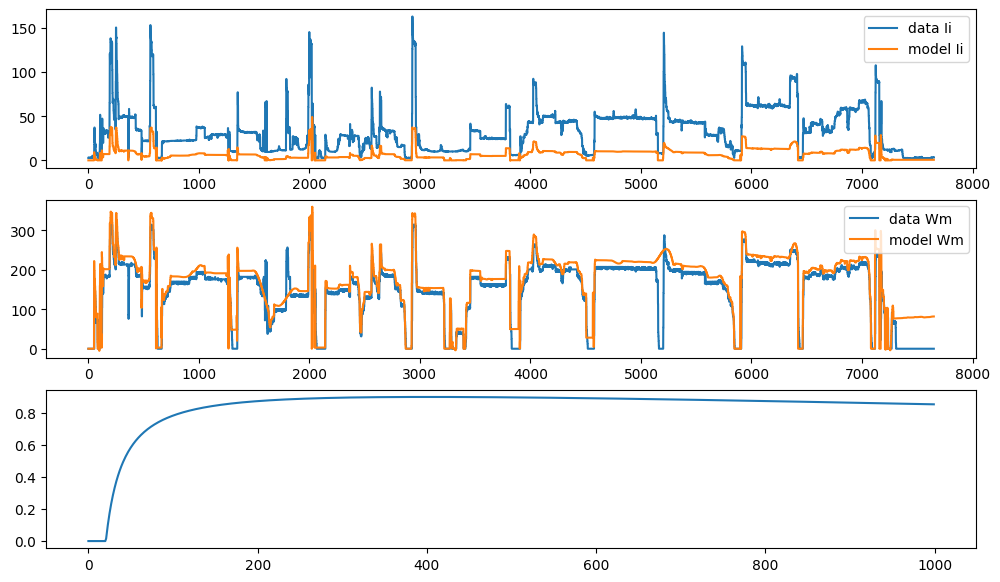

In [38]:
class Propulsion:
    @classmethod
    def build(cls, params: dict):  # TODO: separate params for each model
        return ct.interconnect(
            (
                Propeller.build(params),
                Transmission.build(params),
                Motor.build(params),
                ESC.build(params),
            ),
            name="propulsion",
            connections=[
                ["propeller.Wp", "transmission.Wp"],
                ["transmission.Tp", "propeller.Tp"],
                ["transmission.Wm", "motor.Wm"],
                ["motor.Tm", "transmission.Tm"],
                ["motor.Va", "esc.Vo"],
                ["esc.Io", "motor.Ia"],
            ],
            inplist=["esc.D", "esc.Vi"],
            inputs=["D", "Vi"],
            outlist=["esc.Ii", "motor.Wm"],
            outputs=["Ii", "Wm"],
        )


params = {
    "Ra": 0.03079777,  # Armature Resistance [Ω]
    "La": 28e-6,  # Armature Inductance [Henrys]
    "Bm": 9.3300e-4,  # Mechanical Frictional coeffiecient [Nm/(rad/s)]
    "Jm": 0.002,  # Inertial moment [Kgm²]
    "Kv": 0.10390329,  # Volt-revolution ratio [V/(rad/s)]
    "Kp": 2e-4,  # Propeller torque coefficient
    "D": 8.5 * 0.0254,  # Nominal Propeller diameter (70% of the measured diameter) [m]
    "rho": 1025,  # Water density [kg/m3]
    "trans_eff": 0.8,
    "ctrl_delay_s": 0,  # [s]
    "Kr": 13 / 22, # Transmission's gear ratio as `output speed / input speed`
}
propulsion = Propulsion.build(params)
# display(propulsion.__dict__)

T = (df.index - df.index[0]).to_numpy().astype(
    np.float64
) * 1e-9  # simulation time in seconds
Vbat = df["bat_v"].to_numpy()
D = df["esc_dt"].to_numpy()

res = ct.input_output_response(
    propulsion, T=T, U=[D, Vbat], solve_ivp_kwargs={"method": "Radau"}
)
outputs = res.to_pandas().set_index("time")

fig, ax = plt.subplots(3, figsize=(12, 7))
ax[0].step(T, df["esc_ii"], label="data Ii")
ax[0].step(T, outputs["Ii"], label="model Ii")
ax[0].legend(loc=1)

ax[1].step(T, df["motor_wo"], label="data Wm")
ax[1].step(T, outputs["Wm"], label="model Wm")
ax[1].legend(loc=1)

ax[2].plot(motor_eff(np.ones(1000) * 36, np.linspace(0, 150, 1000), params))
plt.show()


In [11]:
# def func(T, Va, Ra, La, Bm, Jm, Kt, Kv, Kp):
#     params = {
#         "Ra": Ra,
#         "La": La,
#         "Bm": Bm,
#         "Jm": Jm,
#         "Kt": Kt,
#         "Kv": Kv,
#         "Kp": Kp,
#     }
#     solve_ivp_kwargs = {
#         "method": "LSODA",
#         "max_step": 1000,
#         "atol": 1e-6,
#     }

#     return ct.input_output_response(Propulsion.build(params), T, Va, solve_ivp_kwargs=solve_ivp_kwargs).outputs[:2].T


# model = lmfit.Model(
#     func=func,
#     independent_vars=["T", "Va"],
#     param_names=["Ra", "La", "Bm", "Jm", "Kt", "Kv", "Kp"],
# )

# params = lmfit.Parameters()
# params.add_many(
#     # NAME, VALUE, VARY, MIN,  MAX,  EXPR, BRUTE_STEP
#     ("Ra", 25e-3, True, 1e-4, 1e0, None, None),
#     ("La", 28e-6, True, 1e-6, 1e-3, None, None),
#     ("Bm", 3e-3, True, 1e-6, 1e3, None, None),
#     ("Jm", 7e-7, True, 1e-9, 1e-3, None, None),
#     ("Kt", 0.1, True, 1e-2, 5e-1, None, None),
#     ("Kv", 0.1, True, 1e-2, 5e-1, "Kt", None),
#     ("Kp", 1.41584602e-13, True, 1e-9, 1e-6, None, None),
# )


In [12]:
# T = (df.index - df.index[0]).to_numpy().astype(
#     np.float64
# ) * 1e-9  # simulation time in seconds
# Vbat = df["bat_v"].to_numpy()
# D = df["esc_dt"].to_numpy()
# data = df[["esc_ii", "motor_wo"]].copy(deep=True)
# W = D + 1
# W = W / W.max()
# for c in data.columns:
#     data[c] = add_noise(data[c], 20)
# data = data.to_numpy()

# propulsion = Propulsion.build(params.valuesdict())

# result = model.fit(
#     data=data,
#     params=params,
#     # method="least_squares",
#     method="differential_evolution",
#     T=T,
#     D=D,
#     Vbat=Vbat,
#     weights=np.array([W, W]).T,
# )

# fig, ax = plt.subplots(2, figsize=(12, 3*2))
# for i, (initial, best, data) in enumerate(
#     zip(result.init_fit.T, result.best_fit.T, result.data.T)
# ):
#     label = propulsion.output_labels[:2][i].split(".")[1]

#     ax[i].plot(data, label=f"(data) ${label}(t)$")
#     ax[i].plot(initial, ".", label=f"(initial fit) ${label}(t)$")
#     ax[i].plot(best, "--", label=f"(best fit) ${label}(t)$")
#     ax[i].legend(loc=1)

# plt.show()

# result


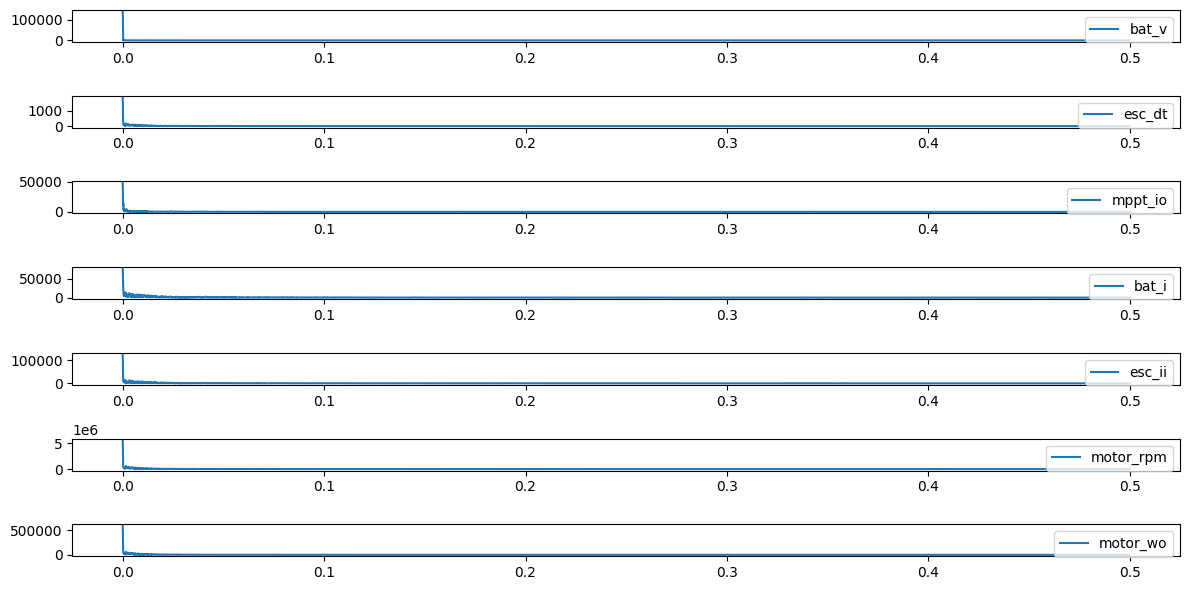

In [13]:
def fft(t, y, N=None, do_log=False):
    dt = t[1] - t[0]
    if N is None:
        N = int(len(y) * 2 - 1)

    w = np.hanning(len(y))
    yf = np.abs(np.fft.rfft(w * y, N))
    xf = np.fft.rfftfreq(N, dt)

    if do_log:
        yf = np.log10(yf)

    return xf, yf


fig, ax = plt.subplots(len(df.columns), figsize=(12, 6))
for i, column in enumerate(df.columns):
    Y = df[column].to_numpy()
    xf, yf = fft(T, Y)

    ax[i].plot(xf[: len(T)], yf[: len(T)], label=column)
    ax[i].legend(loc=1)
plt.tight_layout()
plt.show()


In [41]:
def resid(params, x, ydata):
    T, D, Vbat, W = x
    ymodel = ct.input_output_response(
        Propulsion.build(params.valuesdict()),
        T,
        U=[D, Vbat],
        solve_ivp_kwargs={"method": "Radau"},
    ).outputs.T

    # ymodelf = np.array(
    #     [
    #         fft(T, ymodel[:, 0])[1],
    #         fft(T, ymodel[:, 1])[1],
    #     ]
    # ).T
    # ydataf = np.array(
    #     [
    #         fft(T, ydata[:, 0])[1],
    #         fft(T, ydata[:, 1])[1],
    #     ]
    # ).T

    return np.array([
        ymodel - ydata,
        # ymodelf - ydataf
    ]).flatten()


params = lmfit.Parameters()
params.add_many(
    # NAME, VALUE, VARY, MIN,  MAX,  EXPR, BRUTE_STEP
    ("Ra", 0.03079777, True, 1e-4, 1e0, None, None),  # Armature Resistance [Ω]
    ("La", 28e-6, True, 1e-6, 1e-1, None, None),  # Armature Inductance [Henrys]
    ("Bm", 9.3e-4, True, 1e-6, 1e3, None, None),  # Mechanical Frictional coeffiecient [Nm/(rad/s)]
    ("Jm", 0.2, True, 1e-3, 1e3, None, None),  # Inertial moment [Kgm²]
    ("Kv", 0.10390329, False, 0.1, 0.11, None, None),  # Volt-revolution ratio [V/(rad/s)]
    ("Kp", 2e-4, False, 1e-5, 1e3, None, None),  # Propeller torque coefficient
    ("trans_eff", 0.95, False, 0, 1, None, None),
    ("Kr", 13 / 22, False, 0.1, 1.0, None, None),  # Transmission's gear ratio as `output speed / input speed`
    ("D", 8.5 * 0.0254, False, 1e-3, 3, None, None),  # Nominal Propeller diameter (70% of the measured diameter) [m]
    ("ctrl_delay_s", 1.15, False, 1e-3, 3, None, None),  # [s]
    ("rho", 1025, False, 1000, 1040, None, None),   # Water density [kg/m3]
)

In [42]:
T = (df.index - df.index[0]).to_numpy().astype(
    np.float64
) * 1e-9  # simulation time in seconds
Vbat = df["bat_v"].to_numpy()
D = df["esc_dt"].to_numpy()
data = df[["esc_ii", "motor_wo"]].copy(deep=True)
W = D + 1
W = W / W.max()
# for c in data.columns:
#     data[c] = add_noise(data[c], 10)
data = data.to_numpy()

propulsion = Propulsion.build(params.valuesdict())

result = lmfit.minimize(
    resid,
    params,
    args=([T, D, Vbat, W], data),
    method="least_squares"
    # method="differential_evolution",  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html
    # **dict(
    #     updating="deferred",
    #     disp=True,
    #     polish=True,
    #     workers=32,
    #     max_nfev=100_000,
    #     seed=1,
    #     # strategy="currenttobest1bin",
    #     strategy="randtobest1bin",
    # ),
)

result


In [43]:
"""{'Ra': 0.03079777,
 'La': 2.8e-05,
 'Bm': 0.02414106892244918,
 'Jm': 0.08506121171198605,
 'Kt': 0.10390329,
 'Kv': 0.10390329,
 'Kp': 0.00010322,
 'trans_eff': 0.98,
 'Kr': 0.5909090909090909,
 'ctrl_delay_s': 1.15}"""

result.params.valuesdict()

{'Ra': 0.030797729213717172,
 'La': 2.7915175157903057e-05,
 'Bm': 0.0009302511582335972,
 'Jm': 0.20000027087947483,
 'Kv': 0.10390329,
 'Kp': 0.0002,
 'trans_eff': 0.95,
 'Kr': 0.5909090909090909,
 'D': 0.21589999999999998,
 'ctrl_delay_s': 1.15,
 'rho': 1025}

In [44]:
df_init = ct.input_output_response(
    Propulsion.build(params.valuesdict()),
    T,
    U=[D, Vbat],
    solve_ivp_kwargs={"method": "Radau"},
).to_pandas()[["Ii", "Wm"]]

df_best = ct.input_output_response(
    Propulsion.build(result.params.valuesdict()),
    T,
    U=[D, Vbat],
    solve_ivp_kwargs={"method": "Radau"},
).to_pandas()[["Ii", "Wm"]]


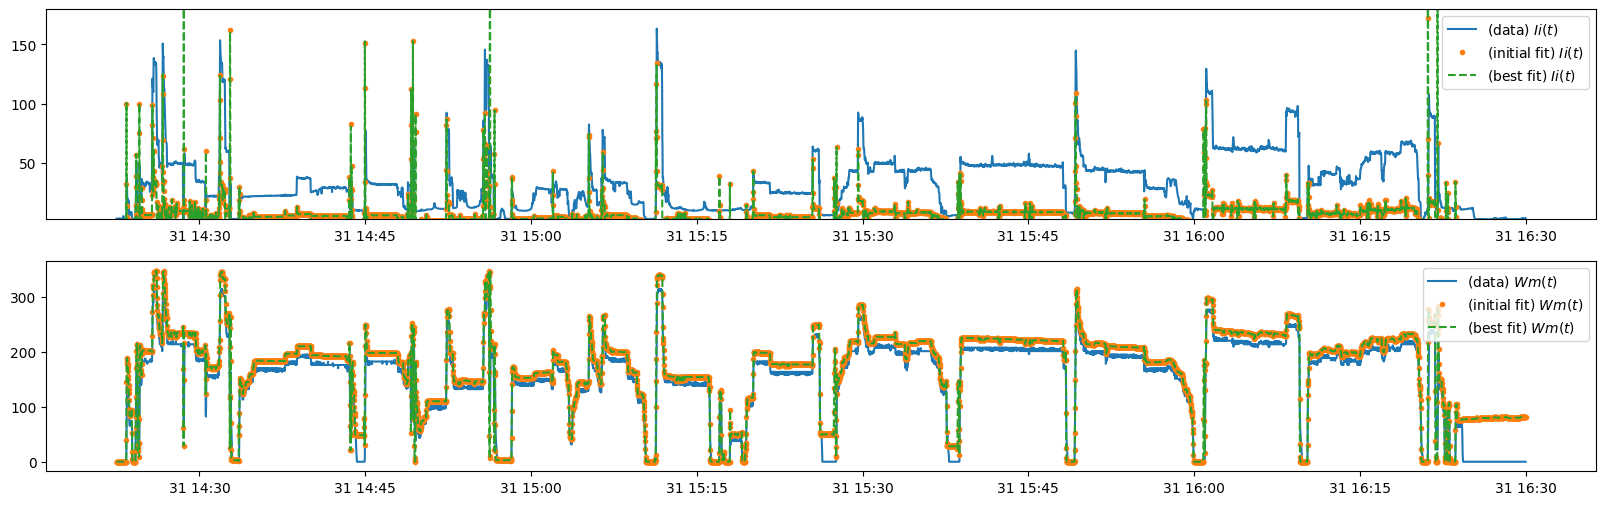

In [45]:
fig, ax = plt.subplots(2, figsize=(20, 3 * 2))

ax[0].plot(df.index, df["esc_ii"], label="(data) $Ii(t)$")
ax[0].plot(df.index, df_init["Ii"], ".", label="(initial fit) $Ii(t)$")
ax[0].plot(df.index, df_best["Ii"], "--", label="(best fit) $Ii(t)$")
ax[0].set_ylim((df["esc_ii"].min()*1.1, df["esc_ii"].max()*1.1))
ax[0].legend(loc=1)

ax[1].plot(df.index, df["motor_wo"], label="(data) $Wm(t)$")
ax[1].plot(df.index, df_init["Wm"], ".", label="(initial fit) $Wm(t)$")
ax[1].plot(df.index, df_best["Wm"], "--", label="(best fit) $Wm(t)$")
ax[1].legend(loc=1)

plt.show()

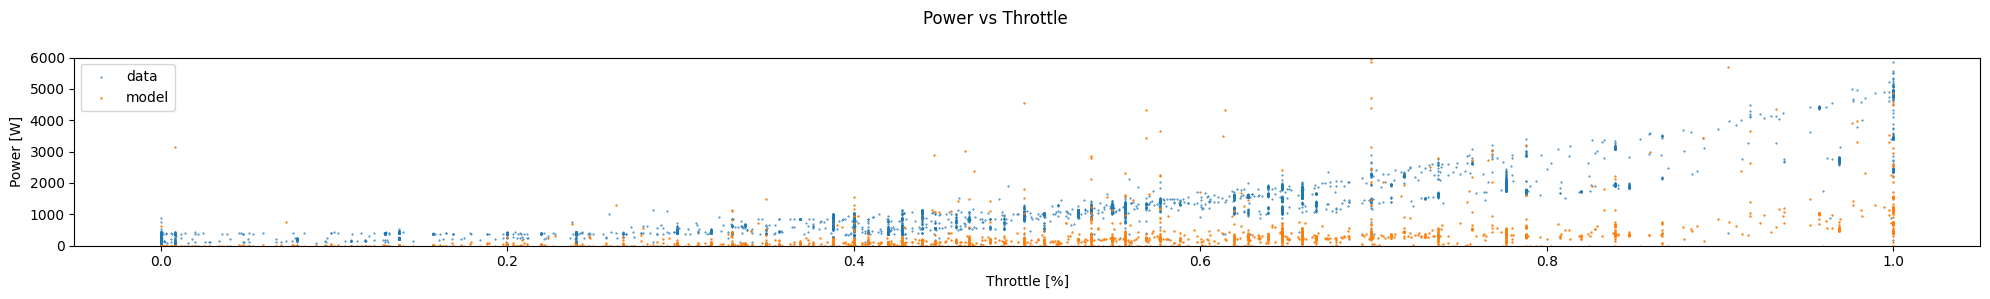

[]

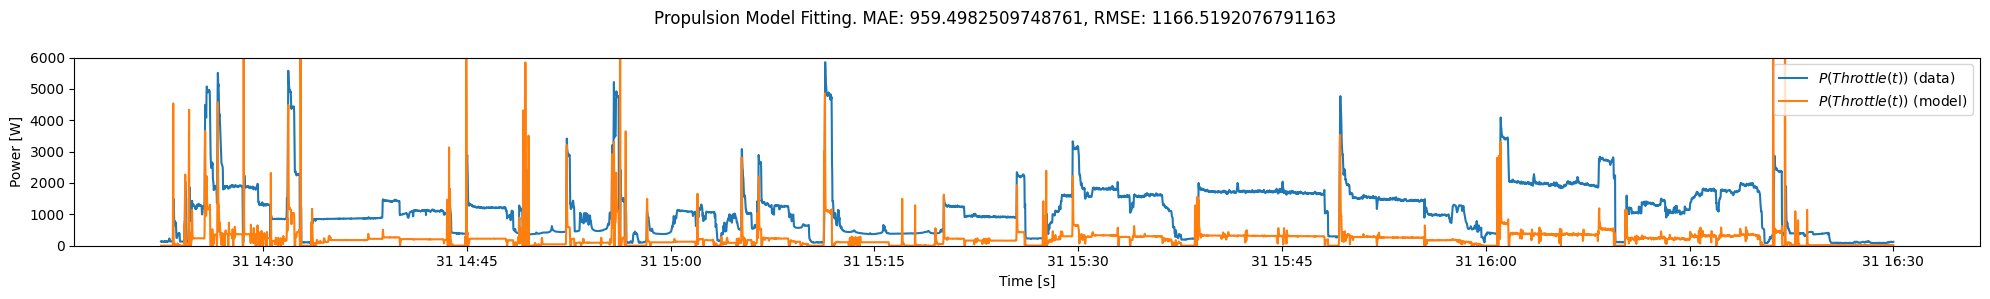

In [46]:
df_best['Ii'] = np.clip(df_best['Ii'].to_numpy(), 0, 200)

df['esc_pi'] = df['esc_ii'] * df['bat_v']
df_best['esc_pi'] = df_best['Ii'].to_numpy() * df['bat_v'].to_numpy()

rmse = (((df['esc_pi'].to_numpy() - df_best['esc_pi'].to_numpy())**2).sum() / len(df))**(1/2)
mae = abs(df['esc_pi'].to_numpy() - df_best['esc_pi'].to_numpy()).sum() / len(df)

plt.figure(figsize=(20,3))
plt.scatter(df['esc_dt'], df['esc_pi'], label='data', s=0.2)
plt.scatter(df['esc_dt'], df_best['esc_pi'], label='model', s=0.5)
plt.xlabel('Throttle [%]')
plt.ylabel('Power [W]')
plt.legend(loc=0)
plt.suptitle('Power vs Throttle')
plt.ylim([0,6000])
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(df.index, df['esc_pi'], label='$P(Throttle(t))$ (data)')
plt.plot(df.index, df_best['esc_pi'], label='$P(Throttle(t))$ (model)')
plt.xlabel('Time [s]')
plt.ylabel('Power [W]')
plt.legend(loc=1)
plt.suptitle(f"Propulsion Model Fitting. MAE: {mae}, RMSE: {rmse}")
plt.ylim([0,6000])
plt.tight_layout()
plt.plot()